In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop5_C0_00090.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C2_00675.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C1_00630.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/Sports_Badminton_C0_00540.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/Taichi_S2_C2_00810.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/Kata_F4_C1_00045.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/Jazz_Jazz3_C0_00630.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images/Ta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import os

from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

Оглавление

* <a href='#link_01'>1. Считывание данных</a>
* <a href='#link_02'>2. Визуализация данных</a>
* <a href='#link_03'>3. Предобработка данных</a>
* <a href='#link_04'>4. Эксперименты с моделями</a>
* <a href='#link_05'>5.1 Валидация модели resnet18</a>
* <a href='#link_06'>5.1 Валидация модели resnet34</a>
* <a href='#link_07'>6. Выводы по работе</a>




<a id='link_01'></a>
1. Считывание данных

In [3]:
image_path = os.path.join("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images")
mask_path = os.path.join("../input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks")
images = os.listdir(image_path)
mask = os.listdir(mask_path)

mask = [fName.split(".png")[0] for fName in mask] 
image_file_name = [fName.split(".png")[0] for fName in mask] 

In [4]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))

In [5]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [ ]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [7]:
dim = 256*2
X_train,y_train = getData(dim)


100%|██████████| 1192/1192 [00:30<00:00, 38.60it/s]


<a id='link_02'></a>
2. Визуализация данных

training set


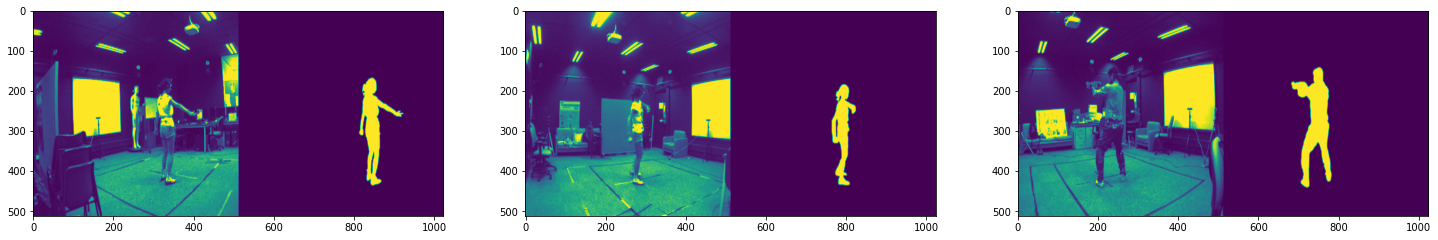

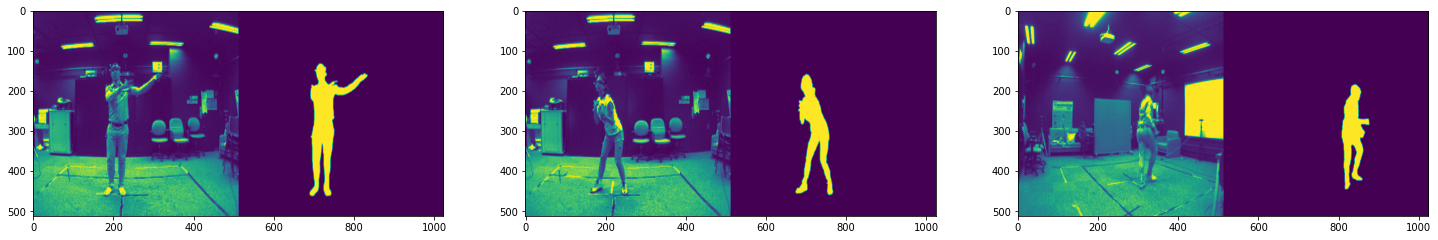

In [8]:
print("training set")
plotMask(X_train,y_train)

<a id='link_03'></a>
3. Предобработка данных 

In [9]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1).astype(np.float32)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1).astype(np.float32)
assert X_train.shape == y_train.shape

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
!pip install segmentation-models


     |████████████████████████████████| 50 kB 1.2 MB/s eta 0:00:01


<a id='link_04'></a>
4. Эксперименты с моделями

In [12]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [13]:
import os
from sklearn.model_selection import train_test_split
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, classes=1,input_shape=(512,512,1),encoder_weights=None)



train_vol, validation_vol, train_seg, validation_seg = train_test_split((X_train-127.0)/127.0, 
                                                            (y_train>127).astype(np.float32), 
                                                            test_size = 0.25,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.25, 
                                                            random_state = 42)


model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])


loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5')

Segmentation Models: using `tf.keras` framework.
Epoch 1/30
84/84 [==============================] - 30s 263ms/step - loss: -0.1513 - dice_coef: 0.1513 - binary_accuracy: 0.7899 - val_loss: -0.1074 - val_dice_coef: 0.1074 - val_binary_accuracy: 0.9284

Epoch 00001: val_loss improved from inf to -0.10739, saving model to cxr_reg_weights.best.hdf5
Epoch 2/30
84/84 [==============================] - 19s 227ms/step - loss: -0.2857 - dice_coef: 0.2857 - binary_accuracy: 0.9775 - val_loss: -0.2727 - val_dice_coef: 0.2727 - val_binary_accuracy: 0.9549

Epoch 00002: val_loss improved from -0.10739 to -0.27268, saving model to cxr_reg_weights.best.hdf5
Epoch 3/30
84/84 [==============================] - 19s 227ms/step - loss: -0.5252 - dice_coef: 0.5252 - binary_accuracy: 0.9897 - val_loss: -0.5236 - val_dice_coef: 0.5236 - val_binary_accuracy: 0.9882

Epoch 00003: val_loss improved from -0.27268 to -0.52358, saving model to cxr_reg_weights.best.hdf5
Epoch 4/30
84/84 [==========================

<a id='link_05'></a>
5.1 Валидация модели resnet18


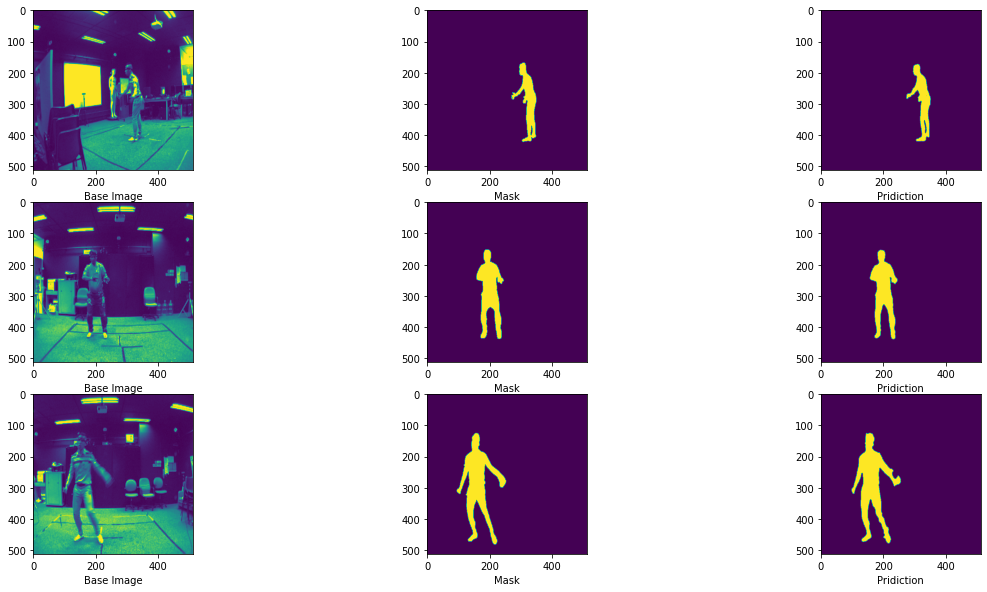

In [14]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [17]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, classes=1,input_shape=(512,512,1),encoder_weights=None)

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])


loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5') 

Epoch 1/30
84/84 [==============================] - 29s 295ms/step - loss: -0.1739 - dice_coef: 0.1739 - binary_accuracy: 0.7683 - val_loss: -0.1242 - val_dice_coef: 0.1242 - val_binary_accuracy: 0.9607

Epoch 00001: val_loss did not improve from -0.95420
Epoch 2/30
84/84 [==============================] - 24s 283ms/step - loss: -0.3986 - dice_coef: 0.3986 - binary_accuracy: 0.9820 - val_loss: -0.3232 - val_dice_coef: 0.3232 - val_binary_accuracy: 0.9785

Epoch 00002: val_loss did not improve from -0.95420
Epoch 3/30
84/84 [==============================] - 24s 283ms/step - loss: -0.6368 - dice_coef: 0.6368 - binary_accuracy: 0.9911 - val_loss: -0.5812 - val_dice_coef: 0.5812 - val_binary_accuracy: 0.9882

Epoch 00003: val_loss did not improve from -0.95420
Epoch 4/30
84/84 [==============================] - 24s 283ms/step - loss: -0.8121 - dice_coef: 0.8121 - binary_accuracy: 0.9942 - val_loss: -0.7709 - val_dice_coef: 0.7709 - val_binary_accuracy: 0.9913

Epoch 00004: val_loss did no

<a id='link_06'></a>
5.2 Валидация модели resnet34


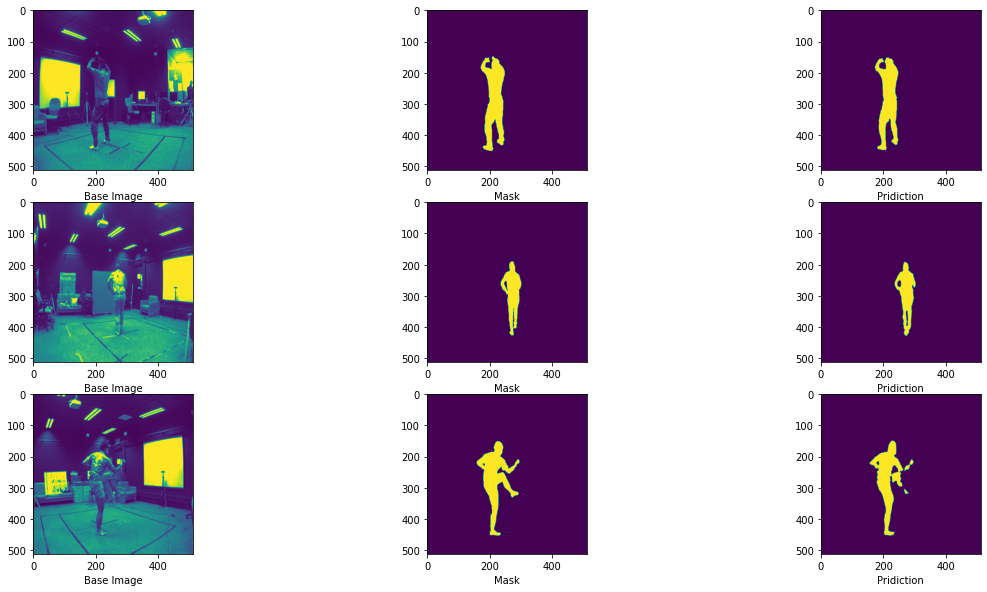

In [18]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

<a id='link_07'></a>
6. Выводы по работе

* Чтобы улучшить результат можно было по пробовать другие архитектуры , resnet обучается быстрее поэтому пробовал его , вероятно другие модели показали бы лучший результат.
* На некоторых масках видны искажения.
* Не хватило опыть работы с нейронками, и с картинками.
* Это только вводный курс а нейронные сети меня очень сильно заинтересовали
* Планирую более детально разобраться tensorflow/keras и предобработкой данных , так как считаю что это очень важный элемент. 